# Extracting the Dataset

In [2]:
import pandas as pd
data=pd.read_csv('Data.csv')
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


# EDA

In [3]:
data.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [4]:
data.shape

(5842, 2)

<Axes: xlabel='Sentiment', ylabel='count'>

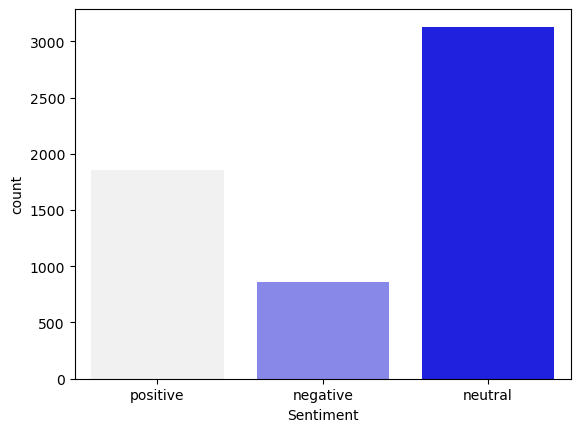

In [5]:
import seaborn as sns
sns.countplot(data, x='Sentiment', palette='light:blue')

In [6]:
data['Sentiment'].value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

## Observations:
1. The dataset has 5842 records with no null valued record and one output column with three diffrent classes 'Positive', 'Negative', 'Neutral'.
2. Neutral records  : 53.57%
   Positive records : 31.7%
   Negative records : 14.72%


# Text preprocessing and Feature Enineering

In [7]:
def convert_to_num(record):
    return {'positive': 1, 'negative': 2}.get(record, 0)

In [8]:
data['Sentiment'] = data['Sentiment'].apply(convert_to_num)
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,1
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",2
2,"For the last quarter of 2010 , Componenta 's n...",1
3,According to the Finnish-Russian Chamber of Co...,0
4,The Swedish buyout firm has sold its remaining...,0


# Importing Stopwords from spacy library

In [9]:
# !python -m spacy download en_core_web_sm

In [10]:
import spacy
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words

# Prepare the text for model 

In [11]:
import re
def text_preprocessing(sentence):
    # Removing numbers, special characters, etc., and replacing them with spaces
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Lemmatization, lowercasing, and removing stop words and punctuation
    tokens = [word.lemma_.lower().strip() for word in nlp(sentence) if not word.is_stop and not word.is_punct]
    return tokens


In [12]:
# Sentences into tokens
data['tokens'] = data['Sentence'].apply(text_preprocessing)
data.head()

,Sentence,Sentiment,tokens
0,The GeoSolutions technology will leverage Bene...,1,"[geosolutions, technology, leverage, benefon, ..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",2,"[, esi, low, , , , bk, real, possibility]"
2,"For the last quarter of 2010 , Componenta 's n...",1,"[quarter, , componenta, , s, net, sale, double..."
3,According to the Finnish-Russian Chamber of Co...,0,"[accord, finnish, russian, chamber, commerce, ..."
4,The Swedish buyout firm has sold its remaining...,0,"[swedish, buyout, firm, sell, remain, , percen..."


# Load the 'word2vec-google-news-300' model from the saved file

In [14]:
from gensim.models import KeyedVectors
saved_model_file = 'word2vec-google-news-300.bin'
w_wec = KeyedVectors.load_word2vec_format(saved_model_file, binary=True)


## Download word2vec-google-news-300 If 'word2vec-google-news-300.bin' file is not present in your system by running the command, the file is approx 1.6 GB

In [5]:
# import gensim.downloader as api
# w_wec = api.load('word2vec-google-news-300')

# Computing the word vector representation of a given list of tokens using pre-trained word vectors

In [17]:
import numpy as np

def word2vec(tokens):
    vector_size = w_wec.vector_size
    
    # Initialize an array of zeros to store the accumulated word vectors
    wv_res = np.zeros(vector_size)
    
    # Initialize a count variable to keep track of the number of valid word vectors encountered
    count = 1
    
    # Iterate through each word in the list of tokens
    for word in tokens:
        # Check if the word exists in the pre-trained word vectors (w_wec)
        if word in w_wec:
            # Increment the count for valid words found
            count += 1
            # Add the word vector of the current word to the result array
            wv_res += w_wec[word]
    
    # Divide the accumulated word vectors by the count to get the average word vector
    wv_res = wv_res / count
    
    return wv_res


In [15]:
data['vectors'] = data['tokens'].apply(word2vec)
data.head()

,Sentence,Sentiment,tokens,vectors
0,The GeoSolutions technology will leverage Bene...,1,"[geosolutions, technology, leverage, benefon, ...","[0.018968854631696428, -0.049512227376302086, ..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",2,"[, esi, low, , , , bk, real, possibility]","[0.01641845703125, 0.004069010416666667, -0.02..."
2,"For the last quarter of 2010 , Componenta 's n...",1,"[quarter, , componenta, , s, net, sale, double...","[0.007249915081521739, 0.08756156589673914, -0..."
3,According to the Finnish-Russian Chamber of Co...,0,"[accord, finnish, russian, chamber, commerce, ...","[-0.07819620768229167, 0.00023698806762695312,..."
4,The Swedish buyout firm has sold its remaining...,0,"[swedish, buyout, firm, sell, remain, , percen...","[0.045985630580357144, -0.03367832728794643, -..."


# Spliting into training and testing set

In [20]:
X = data['vectors'].to_list()
y = data['Sentiment'].to_list()

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=0)

# Importing Selected models

In [25]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

selected_models = {
    "Random Forest" : RandomForestClassifier(),
    "Logistic Regression" : LogisticRegression(),
    "Naive Bayes" : GaussianNB(),
}
   

In [26]:
import numpy as np

hyp_params = {
    "Naive Bayes": {
        "var_smoothing": np.logspace(-9, 0, num=100)
    },
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1.0, 10, 100],
        "penalty": ['l1', 'l2']
    },
    "Random Forest": {
        "n_estimators": [50, 100, 150, 200],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
}


# Training Process with GridSearchCV

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
def train_and_evaluate(X_train, y_train, X_test, y_test, selected_models, hyp_param):
    accu_report = {}
    for i in range(len(list(selected_models))):
        model = list(selected_models.values())[i]
        para = hyp_param[list(selected_models.keys())[i]]

        gs = GridSearchCV(model, para, cv=3)
        gs.fit(X_train, y_train)

        model.set_params(**gs.best_params_)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_model_score = accuracy_score(y_train, y_train_pred)
        test_model_score = accuracy_score(y_test, y_test_pred)

        accu_report[list(selected_models.keys())[i]] = test_model_score

    return accu_report

# Note: The training process takes more 1 hour to complete

In [28]:
Report: dict = train_and_evaluate(
                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, selected_models=selected_models, hyp_param=hyp_params)

c:\Users\mramk\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mramk\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

In [6]:
Report

{'Random Forest': 0.6355859709153122,
 'Logistic Regression': 0.6971770744225834,
 'Naive Bayes': 0.6090675791274593}

# Accuracy from the report

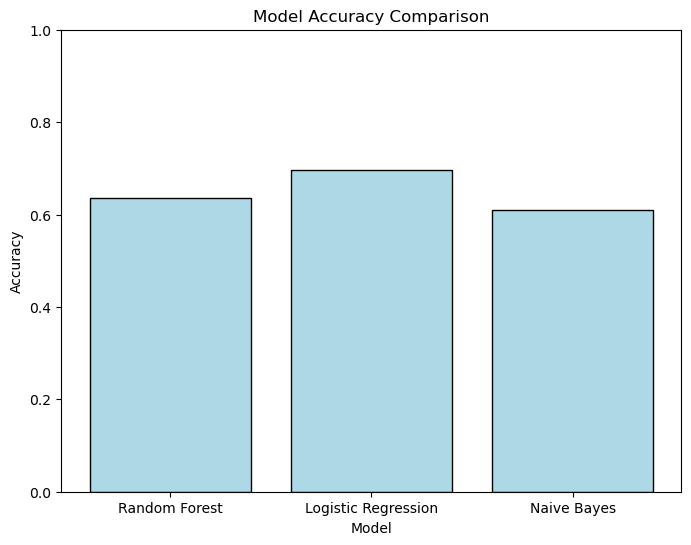

In [4]:
import matplotlib.pyplot as plt
# Accuracy values from the report
model_names = list(Report.keys())
accuracies = list(Report.values())

# Plotting the bar plot
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color='lightblue', edgecolor='black')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)  # Set the y-axis limit to better visualize differences
plt.show()

## Storing Models in a Dictionary to get best model

In [30]:
best_model_score = max(sorted(Report.values()))
best_model_name = list(Report.keys())[
    list(Report.values()).index(best_model_score)
]
best_model = selected_models[best_model_name]
print(best_model)

LogisticRegression()


In [31]:
# Predicting with the best model
y_pred = best_model.predict(X_test)

In [33]:
# Accuracy of the best model
accuracy_score(y_test, y_pred)

0.6971770744225834

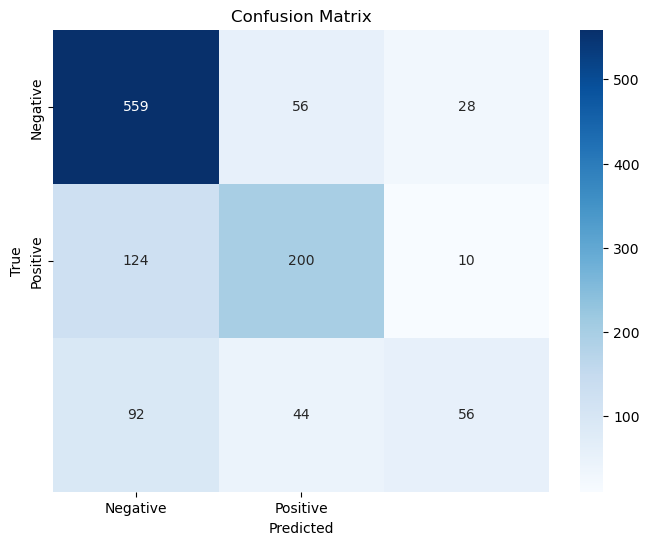

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
# Confusion Matrix of the Best Model
cm=confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Save the model to disk

In [15]:
import pickle
filename = 'finalized_model.pickle'
pickle.dump(best_model, open(filename, 'wb'))

## Loading saved model and predicting on custum input

In [18]:
filename = 'finalized_model.pickle'

# Load the model from the pickle file
loaded_model = pickle.load(open(filename, 'rb'))

input = "$FB gone green on day"
preprocessed_input = text_preprocessing(input)
vector_input = word2vec(preprocessed_input)

In [19]:
pout = loaded_model.predict(vector_input.reshape(1, -1))
output = 'positive' if pout==1 else 'neutral' if pout==0 else 'negative'
print(output)

positive


# Applying Neural Network


In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout

# Convert the lists to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# One-hot encode the target labels for multi-class classification
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

# Build a neural network model with dropout regularization
model = Sequential()
model.add(Dense(128, input_shape=(300,), activation='relu'))
model.add(Dropout(0.2))  # Add a Dropout layer with a dropout rate of 0.2 (20%)
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Add another Dropout layer
model.add(Dense(3, activation='softmax'))  # Use softmax activation for multi-class output

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/20
117/117 [==============================] - 2s 9ms/step - loss: 0.9436 - accuracy: 0.5556 - val_loss: 0.8507 - val_accuracy: 0.6225
Epoch 2/20
117/117 [==============================] - 1s 8ms/step - loss: 0.8140 - accuracy: 0.6383 - val_loss: 0.7887 - val_accuracy: 0.6278
Epoch 3/20
117/117 [==============================] - 1s 9ms/step - loss: 0.7465 - accuracy: 0.6720 - val_loss: 0.7373 - val_accuracy: 0.6642
Epoch 4/20
117/117 [==============================] - 1s 8ms/step - loss: 0.7037 - accuracy: 0.7052 - val_loss: 0.7174 - val_accuracy: 0.6759
Epoch 5/20
117/117 [==============================] - 1s 8ms/step - loss: 0.6618 - accuracy: 0.7138 - val_loss: 0.7258 - val_accuracy: 0.6684
Epoch 6/20
117/117 [==============================] - 1s 8ms/step - loss: 0.6242 - accuracy: 0.7314 - val_loss: 0.7078 - val_accuracy: 0.6727
Epoch 7/20
117/117 [==============================] - 1s 8ms/step - loss: 0.6000 - accuracy: 0.7488 - val_loss: 0.7007 - val_accuracy: 0.6759
Epoch 

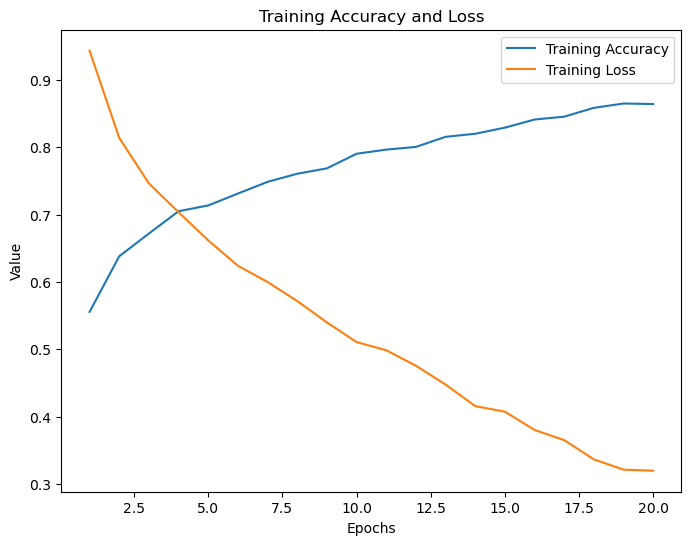

In [91]:
# Get the training accuracy and loss from the history object
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

# Plot training accuracy and loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), train_accuracy, label='Training Accuracy')
plt.plot(range(1, 21), train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Accuracy and Loss')
plt.legend()
plt.show()

In [92]:
# Save the trained model
model.save('sentiment_analysis_model.h5')

## Load the model from the saved file

In [20]:
from tensorflow.keras.models import load_model

loaded_model = load_model('sentiment_analysis_model.h5')

In [22]:
# Get user input
user_input = "The company is doing great"

# Preprocess the user input
preprocessed_input = text_preprocessing(user_input)

# Convert the preprocessed input to word vectors
user_vector = word2vec(preprocessed_input)

# Reshape the user vector to be compatible with the model
user_vector = user_vector.reshape(1, -1)

# Use the trained neural network model to predict the sentiment
predicted_probabilities = loaded_model.predict(user_vector)

# Get the index of the highest probability as the predicted class
predicted_class_index = np.argmax(predicted_probabilities)

# Map the predicted class index to the corresponding sentiment
sentiment_mapping = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
predicted_sentiment = sentiment_mapping[predicted_class_index]

print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Positive
